# 0: Set Up

Import Libraries

In [3]:
# from feat.utils.io import read_feat
import os
import pandas as pd
import re
import scipy.stats as stats
from statsmodels.multivariate.manova import MANOVA
import seaborn as sns
import matplotlib.pyplot as plt

# 1: Read Data

## 1.1: Concatenate data into single dataframe

In [13]:
def concat_annotation_files(directory:str, speaking_only:bool=False):
    """
    """
    dfs = []
    for root, dirs, files in os.walk(directory):
        for file_name in files:
            # Verify file name
            match = re.search(r"([S\d+])_([2-9])([0-9]{2})([0-9])\-([0-9]+)\.csv$", file_name) # Skip "Anxiety"
            if match:
                participant_id = "S0" + match.group(1)
                category = int(match.group(2))
                take = int(match.group(3)) + 1
                part = int(match.group(4))
                video_splice_number = int(match.group(5))

                # Read file & append dataframe to list
                if not speaking_only or video_splice_number % 2 == 0:
                    df = pd.read_csv(os.path.join(root, file_name), usecols=lambda col: col.startswith("AU") or col == "frame", low_memory=False)
                    df["filename"] = file_name
                    df["participant_id"] = participant_id
                    df["category"] = 0 if category == 2 else 1
                    df["take"] = take
                    df["part"] = part
                    df["video_splice_number"] = video_splice_number
                    df = df.iloc[::4, :]                                # 120fps -> 30fps
                    dfs.append(df)

    # Combine dataframes and re-order columns
    cols_custom_order = ["filename", "participant_id", "category", "take", "part", "video_splice_number", "frame"]
    keep_AU_cols = ["AU01_r", "AU02_r", "AU04_r", "AU05_r", "AU06_r", "AU09_r", "AU10_r", "AU12_r", "AU14_r", "AU15_r", "AU17_r", "AU20_r", "AU25_r", "AU26_r",
                    "AU04_c", "AU12_c", "AU15_c", "AU23_c","AU28_c", "AU45_c"]
    combined_df = pd.concat(dfs, ignore_index=True)
    cols = cols_custom_order + keep_AU_cols
    combined_df = combined_df[cols]

    return combined_df

In [14]:
df = concat_annotation_files('../../data/FacialAnnotations/OpenFace/Type 01', speaking_only=False)
print(f"Unique videos: {df.filename.nunique()}")
print(f"Total processed frames: {df.shape[0]}")
print(f"Avg frames per video: {df.groupby('filename').size().mean()}")
print(f"Memory used: {df.memory_usage(deep=True).sum() / (1024 **3)} GB")

Unique videos: 780
Total processed frames: 356867
Avg frames per video: 457.5217948717949
Memory used: 0.11025343649089336 GB


## 1.2: Preview

In [15]:
df.head()

,filename,participant_id,category,take,part,video_splice_number,frame,AU01_r,AU02_r,AU04_r,...,AU17_r,AU20_r,AU25_r,AU26_r,AU04_c,AU12_c,AU15_c,AU23_c,AU28_c,AU45_c
0,S01_2001-1.csv,S01,0,1,1,1,1,0.0,0.0,2.24,...,0.00,0.11,1.78,1.86,1.0,0.0,0.0,0.0,0.0,0.0
1,S01_2001-1.csv,S01,0,1,1,1,5,0.0,0.0,1.81,...,0.01,0.27,1.94,1.79,1.0,0.0,0.0,0.0,0.0,0.0
2,S01_2001-1.csv,S01,0,1,1,1,9,0.0,0.0,1.93,...,0.27,0.45,1.47,1.90,1.0,0.0,0.0,1.0,0.0,0.0
3,S01_2001-1.csv,S01,0,1,1,1,13,0.0,0.0,1.71,...,0.12,0.07,1.17,1.39,1.0,0.0,0.0,1.0,0.0,0.0
4,S01_2001-1.csv,S01,0,1,1,1,17,0.0,0.0,1.82,...,0.34,0.00,0.66,0.73,1.0,0.0,0.0,1.0,0.0,0.0


Define column groups

In [19]:
# Filter columns starting with 'AU'
AU_cols = df.filter(like='AU').columns
AU_cols_cont = df.filter(regex="AU\d+_r").columns
AU_cols_bin = df.filter(regex="AU\d+_c").columns


AU means for each category

<Axes: >

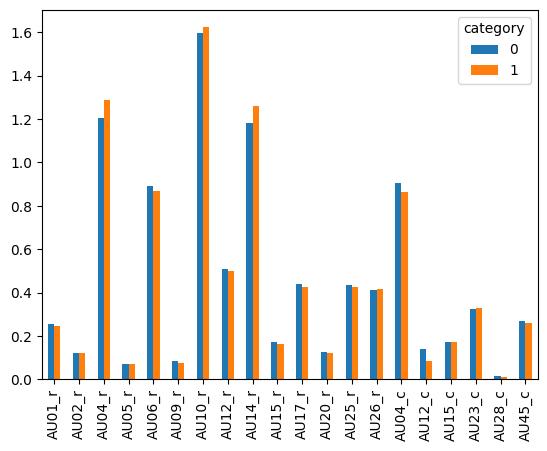

In [20]:
# Group by the extracted keys and calculate mean for AU columns
AU_means = df.groupby(['category'])[AU_cols].mean().T

AU_means.plot(kind='bar')

# 2: Statistical Tests

## 2.1: Individual AUs

One-Way ANOVA for Continuous AUs

In [21]:
def one_way_anova(df, continuous_aus):
    results = {}
    for au_col in continuous_aus:
        groups = [df[df["category"] == cat][au_col].dropna() for cat in df["category"].unique()]
        f_stat, p_value = stats.f_oneway(*groups)
        results[au_col] = {"F-Statistic": f_stat, "P-Value": p_value}
    return results

# Run One-Way ANOVA
one_way_anova_results = one_way_anova(df, AU_cols_cont)

for key, values in one_way_anova_results.items():
    print(key, values)

AU01_r {'F-Statistic': 27.049841529360027, 'P-Value': 1.9838554590801017e-07}
AU02_r {'F-Statistic': 0.11068142505500127, 'P-Value': 0.7393698681303509}
AU04_r {'F-Statistic': 522.8359289671977, 'P-Value': 1.2386673349978764e-115}
AU05_r {'F-Statistic': 0.4421121056605578, 'P-Value': 0.5061052191608216}
AU06_r {'F-Statistic': 64.26839289616397, 'P-Value': 1.0889792911925979e-15}
AU09_r {'F-Statistic': 101.56714494849919, 'P-Value': 6.959244985473137e-24}
AU10_r {'F-Statistic': 138.09815614530928, 'P-Value': 7.030839466185728e-32}
AU12_r {'F-Statistic': 27.5382596489069, 'P-Value': 1.5410513667847297e-07}
AU14_r {'F-Statistic': 892.5169773945702, 'P-Value': 7.261761206401815e-196}
AU15_r {'F-Statistic': 47.78529845975087, 'P-Value': 4.763375253480568e-12}
AU17_r {'F-Statistic': 87.41749614145762, 'P-Value': 8.83521013467295e-21}
AU20_r {'F-Statistic': 21.331238778495, 'P-Value': 3.865181048263999e-06}
AU25_r {'F-Statistic': 13.616968657522568, 'P-Value': 0.0002241836125495463}
AU26_r {'

Chi-Square for Binary AUs

In [22]:
def chi_square_for_all(df, binary_aus):
    results = {}
    for au_col in binary_aus:
        contingency_table = pd.crosstab(df[au_col], df["category"])
        chi2_stat, p_value = stats.chi2_contingency(contingency_table)[:2]
        results[au_col] = {"Chi2-Statistic": chi2_stat, "P-Value": p_value}
    return results

# Run Chi-Square Tests
chi2_results = chi_square_for_all(df, AU_cols_bin)

for key, values in chi2_results.items():
    print(key, values)

AU04_c {'Chi2-Statistic': 1182.6407167389896, 'P-Value': 3.6139198767991143e-259}
AU12_c {'Chi2-Statistic': 2219.1707451157104, 'P-Value': 0.0}
AU15_c {'Chi2-Statistic': 2.945726546535248, 'P-Value': 0.0861049709966773}
AU23_c {'Chi2-Statistic': 11.416840118680199, 'P-Value': 0.0007278137532326757}
AU28_c {'Chi2-Statistic': 53.71072452517655, 'P-Value': 2.322917828016284e-13}
AU45_c {'Chi2-Statistic': 43.61860516993711, 'P-Value': 3.9902737079575766e-11}


## 2.2: Multiple AUs

MANOVA for all continuous AUs at once

In [23]:
# Run MANOVA with all AUs as dependent variables
def run_manova(df, au_cols):
    formula = ' + '.join(au_cols)
    model = MANOVA.from_formula(f'{formula} ~ C(category)', data=df)
    return model.mv_test()

manova_results = run_manova(df, AU_cols_cont)
print(manova_results)

                     Multivariate linear model
                                                                    
--------------------------------------------------------------------
       Intercept        Value   Num DF    Den DF    F Value   Pr > F
--------------------------------------------------------------------
          Wilks' lambda 0.2601 14.0000 356852.0000 72497.6150 0.0000
         Pillai's trace 0.7399 14.0000 356852.0000 72497.6150 0.0000
 Hotelling-Lawley trace 2.8442 14.0000 356852.0000 72497.6150 0.0000
    Roy's greatest root 2.8442 14.0000 356852.0000 72497.6150 0.0000
--------------------------------------------------------------------
                                                                    
--------------------------------------------------------------------
        C(category)       Value   Num DF    Den DF   F Value  Pr > F
--------------------------------------------------------------------
            Wilks' lambda 0.9913 14.0000 356852.0000 222

In [24]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Two-Way ANOVA with interaction
def run_two_way_anova_with_interaction(df, au_cols):
    results = {}
    for au_col in au_cols:
        formula = f"{au_col} ~ C(category) + C(participant_id) + C(category):C(participant_id)"
        model = ols(formula, data=df).fit()
        anova_table = anova_lm(model, typ=2)
        results[au_col] = anova_table
    return results

two_way_anova_results = run_two_way_anova_with_interaction(df, AU_cols_cont)

# Check for significant interaction effects
for au, table in two_way_anova_results.items():
    print(f"Two-Way ANOVA Results for {au}:\n", table)

Two-Way ANOVA Results for AU01_r:
                                      sum_sq        df            F  \
C(category)                        3.859579       1.0    18.696800   
C(participant_id)               1244.067232       6.0  1004.430597   
C(category):C(participant_id)     43.240116       6.0    34.911052   
Residual                       73665.140065  356853.0          NaN   

                                     PR(>F)  
C(category)                    1.532809e-05  
C(participant_id)              0.000000e+00  
C(category):C(participant_id)  1.884697e-42  
Residual                                NaN  
Two-Way ANOVA Results for AU02_r:
                                      sum_sq        df           F  \
C(category)                        0.125215       1.0    1.214980   
C(participant_id)                325.707276       6.0  526.732692   
C(category):C(participant_id)     16.356046       6.0   26.450942   
Residual                       36776.914343  356853.0         NaN   

   

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Function to prepare data
def prepare_time_series_data(df, au_col, exclude_ids=["S01", "S05"]):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for participant_id, group in df.groupby(["participant_id", 'category', "take", "part"]):
        participant_data = group[au_col].values
        label = group["category"].iloc[0]  # Get the category for this participant_id, take, and part

        if participant_id[0] in exclude_ids:
            test_data.append(participant_data)
            test_labels.append(label)
        else:
            train_data.append(participant_data)
            train_labels.append(label)

    return (
        np.array(train_data),
        np.array(test_data),
        np.array(train_labels),
        np.array(test_labels),
    )

# Prepare data
X_train, X_test, y_train, y_test = prepare_time_series_data(df, "AU45_c") # Input any AU column

# Handle potential missing data (e.g., unequal number of frames)
# Pad to the maximum input length
max_length = max([len(x) for x in np.concatenate([X_train, X_test])])
X_train = np.array([np.pad(x, (0, max_length - len(x)), constant_values=0) for x in X_train])
X_test = np.array([np.pad(x, (0, max_length - len(x)), constant_values=0) for x in X_test])

# Train a random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Test the classifier
y_pred = clf.predict(X_test)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         9

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



C:\Users\bryan\AppData\Local\Temp\ipykernel_25648\3624336322.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(train_data),
C:\Users\bryan\AppData\Local\Temp\ipykernel_25648\3624336322.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(test_data),
